# 1.1 How to use VGG

In [4]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
from torchvision import models, transforms

In [5]:
torch.__version__

'1.2.0'

In [6]:
torchvision.__version__

'0.4.0'

In [8]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
net.eval()

print(net)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/tokunagamasaomi/.cache/torch/checkpoints/vgg16-397923af.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
class BaseTransform():
    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    def __call__(self, img):
        return self.base_transform(img)

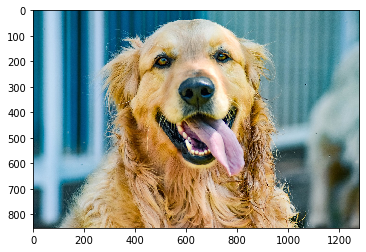

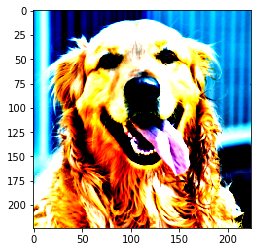

In [13]:
#1. Load image
image_file_path = './data/goldenretriever-3724972_1280.jpg'
img = Image.open(image_file_path)

#2. Show original image
plt.imshow(img)
plt.show()

resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.224)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [15]:
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json','r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [16]:
class ILSVRCPredictor():
    def __init__(self, class_index):
        self.class_index = class_index
        
    def predict_max(self, out):
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]
        
        return predicted_label_name

In [21]:
 #1 Load class index
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json','r'))

#2 Predictor instance
predictor = ILSVRCPredictor(ILSVRC_class_index)

#3 Load image
image_file_path = './data/goldenretriever-3724972_1280.jpg'
img = Image.open(image_file_path)

#4 Transform and Add batch size
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)
inputs = img_transformed.unsqueeze_(0)

#5 Output and Take maximum
out=net(inputs)
result = predictor.predict_max(out)

print(result)

golden_retriever


# 1.3 Transfer Learning

**Dataset** -> **DataLoader** -> **Model** -> (Forward) -> **Loss Func** -> **Optimizer** -> **Train and Validate**

In [24]:
import tqdm
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [25]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## Create Dataset 
Transform Class → List of file paths → Dataset Class

### Transform

In [44]:
#Preprocessing
#For each train and valid

class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(.5,1.)), # Data Augmentation
                transforms.RandomHorizontalFlip(), # Data Augmentation
                transforms.ToTensor(), # Convert to Tensor
                transforms.Normalize(mean, std), # Normalization
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize), # Resize
                transforms.CenterCrop(resize), # Crop resize X resize
                transforms.ToTensor(), # Conver to Tensor
                transforms.Normalize(mean, std) # Normalization
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

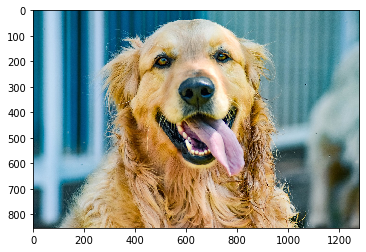

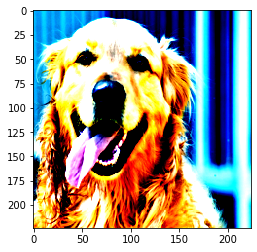

In [46]:
image_file_path = './data/goldenretriever-3724972_1280.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train')

# (color, height, width) -> (height, width, color)
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
# Delimit from 0 to 1
img_transformed = np.clip(img_transformed,0,1)
plt.imshow(img_transformed)
plt.show()

### List of image path

In [50]:
def make_data_path_list(phase='train'):
    rootpath = './data/hymenoptera_data/'
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

train_list = make_data_path_list('train')
val_list = make_data_path_list('val')

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/ants/0013035.jpg',
 './data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train/ants/132478121_2a430adea2.jpg',
 './data/hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg',
 './data/hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg',
 './data/hymenoptera_data/train/ants/1473187633_63ccaacea6.jpg',
 './data/hymenoptera_data/train/ants/148715752_302c84f5a4.jpg',
 './data/hymenoptera_data/train/ants/1489674356_09d48dde0a.jpg',
 './data/hymenoptera_data/train/ants/14924

### Dataset Class

In [52]:
class HymenopteraDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        # Load image
        img_path = self.file_list[index]
        img = Image.open(img_path) #(height, width, color)
        
        # Transform image
        img_transformed = self.transform(img, self.phase)
        
        # Determine Label
        if self.phase == 'train':
            label = img_path[30:34]
        elif self.phase == 'val':
            label = img_path[28:32]
            
        if label == 'ants':
            label = 0
        elif label == 'bees':
            label = 1
            
        return img_transformed, label

In [53]:
train_dataset = HymenopteraDataset(train_list, ImageTransform(size, mean, std), 'train')
val_dataset = HymenopteraDataset(val_list, ImageTransform(size, mean,std),'val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


## Create DataLoader
Each train and validation DataLoader → dataloaders_dict

In [54]:
batch_size = 32

#DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#Dictionary of dataloaders
dataloaders_dict = {'train':train_dataloader, 'val':val_dataloader}

In [55]:
# Convert to iterator
batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 1])


## Create Network Model
Using pretrained VGG16

In [59]:
use_pretrained = True
net = models.vgg16(pretrained = use_pretrained)

# Replace the output layer of the classifier in VGG16
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# Set train mode
net.train()

print('Network setting done: Loaded the pretrained weights and Set the train mode.')

Network setting done: Loaded the pretrained weights and Set the train mode.


## Loss Function
Negative log likelihood loss

In [60]:
criterion = nn.CrossEntropyLoss()

## Optimizer

In [64]:
for name, _ in net.named_parameters():
    print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [66]:
params_to_update=[]
update_param_names=['classifier.6.weight', 'classifier.6.bias']

# Unfreeze specific layers
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
        
# Optimizer
optimizer = optim.SGD(params=params_to_update, lr=.001, momentum=.9)

classifier.6.weight
classifier.6.bias


## Train and Test

In [68]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('------------------')
        
        # For each train and val per epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # Set train mode
            else:
                net.eval() # Set val mode
                
            epoch_loss = 0. # One epoch total loss
            epoch_corrects = 0 # Number of correction in one epoch
            
            # Skip epoch=0 because wants to check the performance of untrained model.
            if (epoch == 0) and (phase=='train'):
                continue
            
            # Train in one minibatch
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                # Initialize optimizer
                optimizer.zero_grad()
                
                # Forward(Calculate gradients only in Training)
                # Disable the calculation of gradients of NN when the phase is not 'train'.
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    # Calculate loss
                    loss = criterion(outputs, labels)
                    # Prediction labels
                    _, preds = torch.max(outputs, 1)
                    
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            # Epoch Loss and Acc
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                    

In [69]:
num_epochs=2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/2
------------------


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.7326 Acc: 0.4641
Epoch 2/2
------------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.4680 Acc: 0.7942


100%|██████████| 5/5 [01:07<00:00, 13.50s/it]

val Loss: 0.1784 Acc: 0.9412
